# Advanced Lane Finding Project

1. Camera calibration
2. Distortion correction
3. Color/gradient threshold
4. Perspective transform
After doing these steps, you’ll be given two additional steps for the project:
1. Detect lane lines
2. Determine the lane curvature


## Camera Calibration

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pylab

%matplotlib inline

def run_once(f):
    def wrapper(*args, **kwargs):
        if not wrapper.has_run:
            wrapper.has_run = True
            return f(*args, **kwargs)
    wrapper.has_run = False
    return wrapper

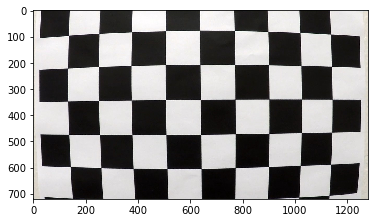

In [2]:
# read image and plot
eximg = mpimg.imread("camera_cal/calibration1.jpg")
plt.imshow(eximg)

In [3]:
# Setup arrays to store object and image points

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

In [4]:
# data_points function to read image and append to arrays

def data_points(image):
    # Prepare object points with with number of rows by columns in inner points 
    objp = np.zeros((5*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:5].T.reshape(-1,2) # this is the x, y coordinates
    
    # convert image to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,5),None)

    # check if corners are found and add to object and image points array
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        # draw and display the corners
        image = cv2.drawChessboardCorners(image, (9,5), corners, ret)
        plt.imshow(image)    

# function cal_undistort to undistort image
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_camera(objpoints, imgpoint, img):
    # Get image shape
    img_size = img.shape[0:2]

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    return ret, mtx, dist, undistorted

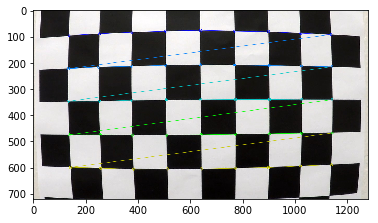

In [5]:
import glob

# read in and make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

for fname in images:
    img = mpimg.imread(fname)
    data_points(img)

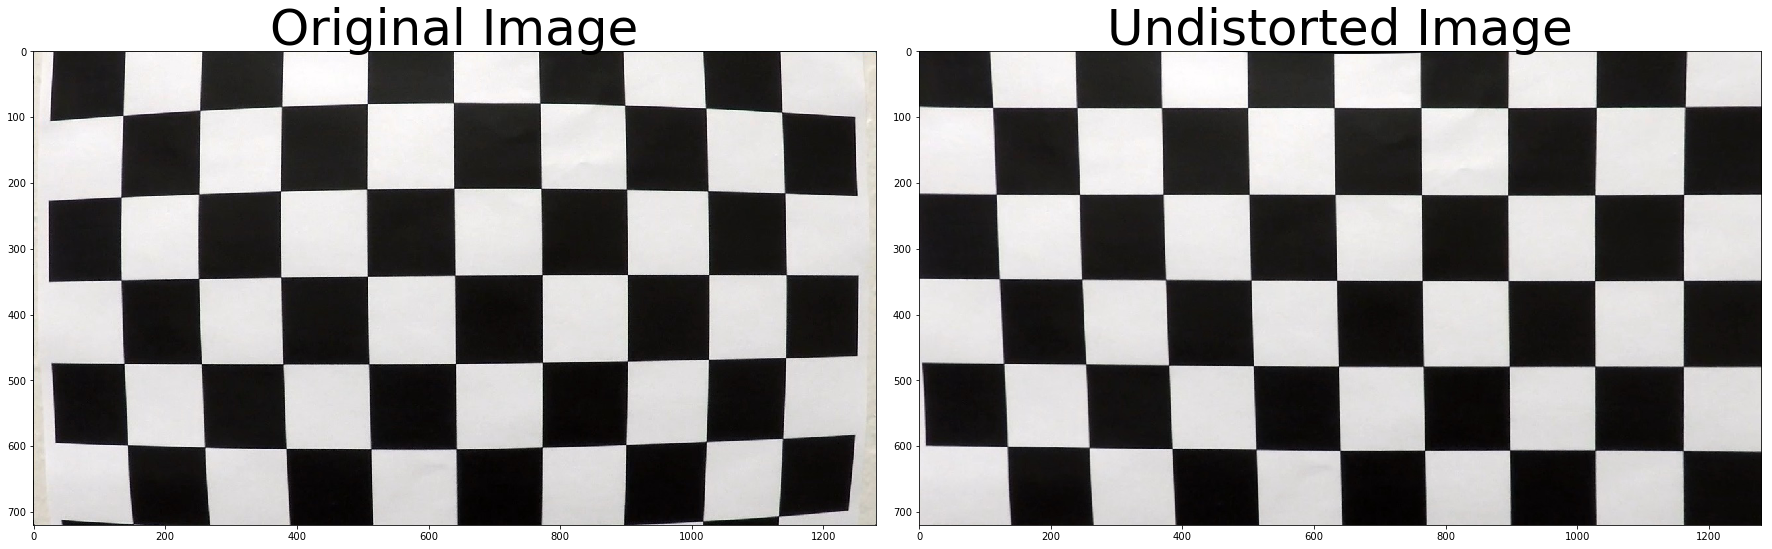

In [6]:
ret, mtx, dist, undistorted = cal_camera(objpoints, imgpoints, eximg)

cv2.imwrite('output_images/cal_camera_distort.jpg', undistorted)
cv2.imwrite('output_images/cal_camera_undistort.jpg', undistorted)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(eximg)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



## Distortion Correction

In [7]:
# Import everything needed to edit/save/watch video clips
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def extract_frames(movie, times, imgdir):
    clip = VideoFileClip(movie)
    for t in times:
        imgpath = os.path.join(imgdir, '{}.jpg'.format(t))
        clip.save_frame(imgpath, t)
        
def undist_vid(img, mtx=mtx, dist=dist):
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted

In [8]:
movie = 'project_video.mp4'
imgdir = 'frames'
times = 0.6, 1.1, 22, 39, 40, 41, 41.5, 42

extract_frames(movie, times, imgdir)

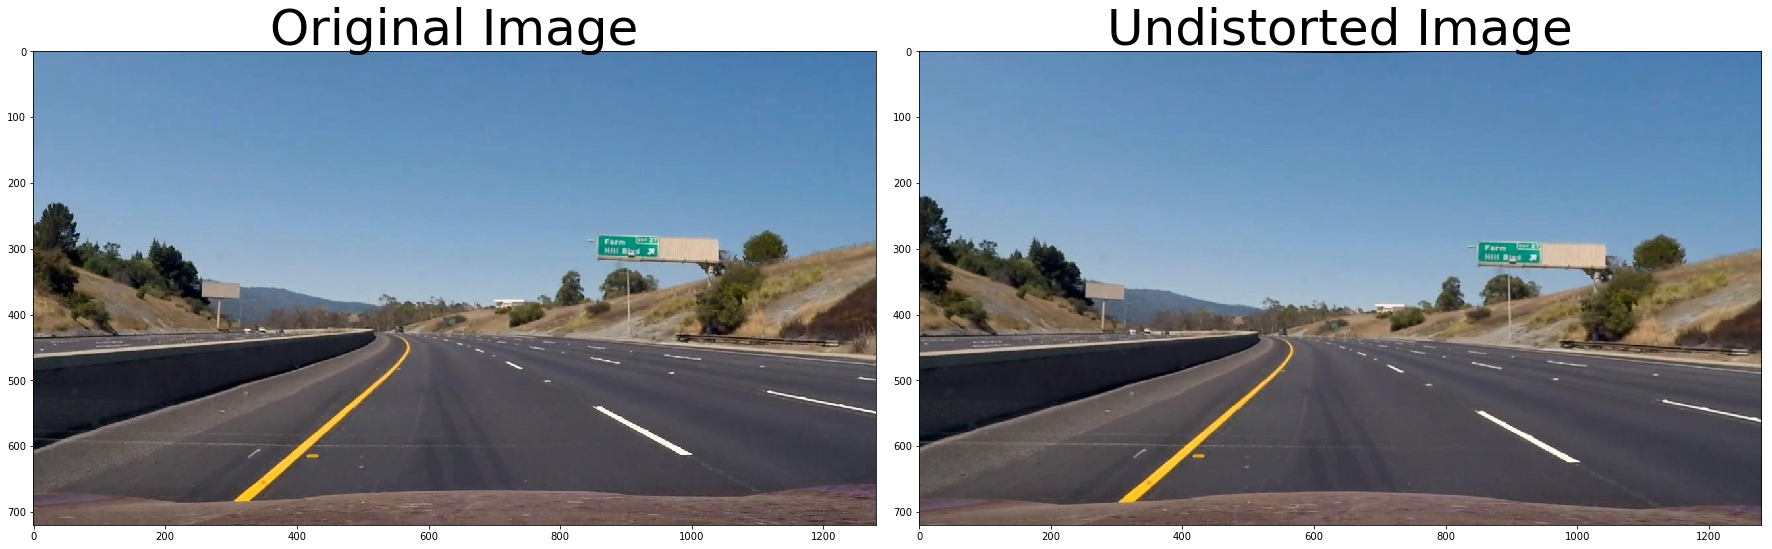

In [9]:
img = mpimg.imread("frames/1.1.jpg")

undistorted = undist_vid(img)

cv2.imwrite('output_images/car_camera_distort.jpg', img[:,:,::-1])
cv2.imwrite('output_images/car_camera_undistort.jpg', undistorted[:,:,::-1])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [10]:
import glob

# read in and make a list of calibration images
images = glob.glob('test_images/*.jpg')

for fname in images:
    # Read each image
    img = mpimg.imread(fname)
    filename = fname.split(os.sep)[-1]
    filename = filename.split('.')[0]
    # Undistort image
    undistorted = undist_vid(img)
    # Save images
    imgdir = 'output_images/'
    img_dis = os.path.join(imgdir, '{}_distort.jpg'.format(filename))
    img_undis = os.path.join(imgdir, '{}_undistort.jpg'.format(filename))
    
    cv2.imwrite(img_dis, img[:,:,::-1])
    cv2.imwrite(img_undis, undistorted[:,:,::-1])
    print (img_dis)
    print (img_undis)

output_images/straight_lines1_distort.jpg
output_images/straight_lines1_undistort.jpg
output_images/straight_lines2_distort.jpg
output_images/straight_lines2_undistort.jpg
output_images/test1_distort.jpg
output_images/test1_undistort.jpg
output_images/test2_distort.jpg
output_images/test2_undistort.jpg
output_images/test3_distort.jpg
output_images/test3_undistort.jpg
output_images/test4_distort.jpg
output_images/test4_undistort.jpg
output_images/test5_distort.jpg
output_images/test5_undistort.jpg
output_images/test6_distort.jpg
output_images/test6_undistort.jpg


## Colour and Gradient Threshold

In [11]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    #grad_binary = np.zeros_like(gradmag)
    #grad_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    binary_output = gradmag
    
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary

def region_of_interest(img, left_fitx, right_fitx):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by "vertices" with the fill color    
    # cv2.fillPoly(mask, vertices, ignore_mask_color)
    cv2.fillPoly(mask, np.int_([left_line_pts]), ignore_mask_color)
    cv2.fillPoly(mask, np.int_([right_line_pts]), ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

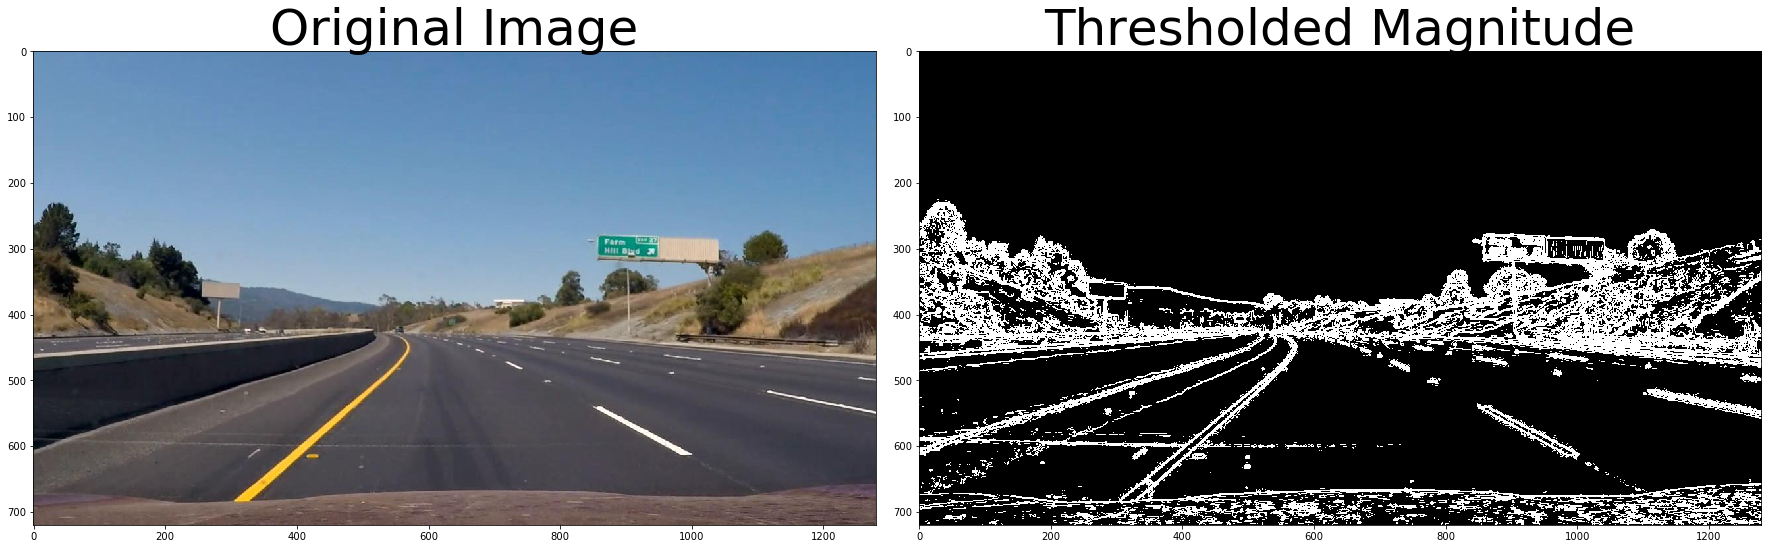

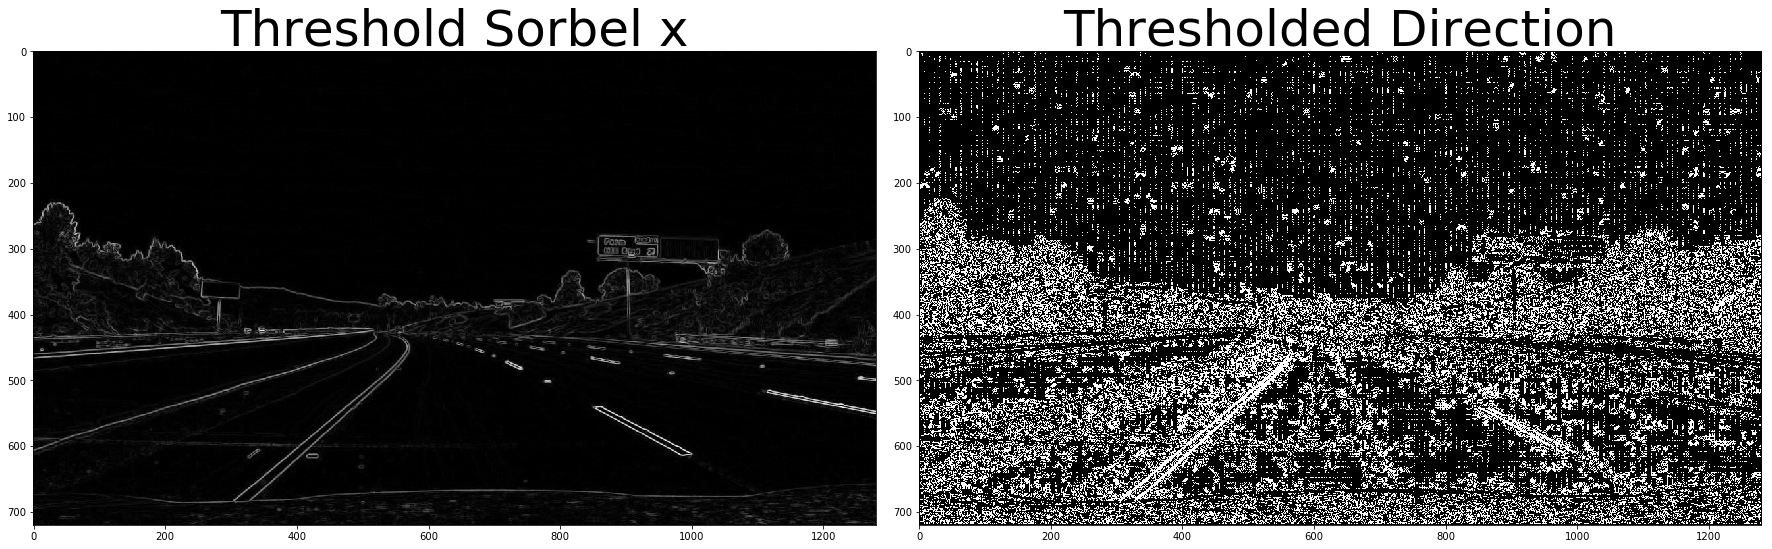

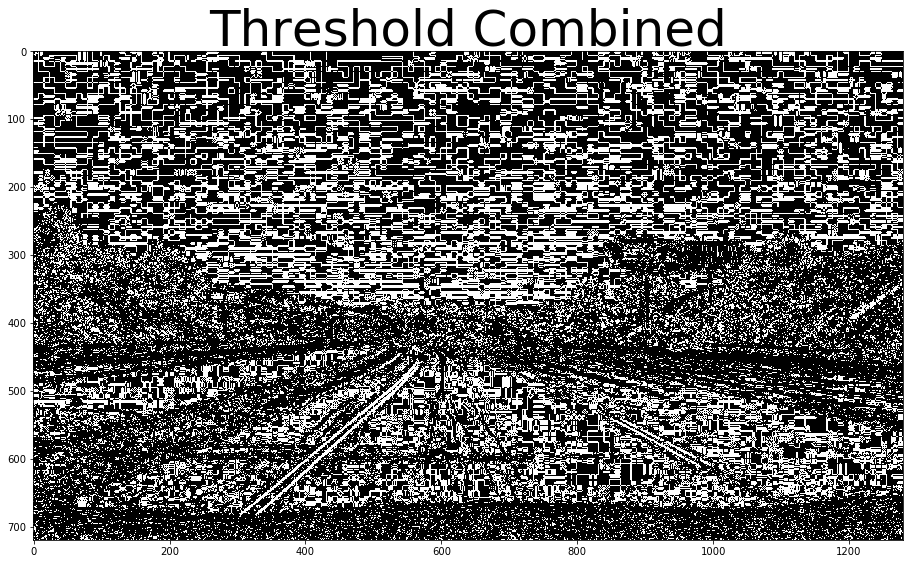

In [12]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

image = mpimg.imread('frames/1.1.jpg')

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(10, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.5, 1.2))

# Combine images
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
pylab.savefig('output_images/car_camera_org_mag_binary.png')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gradx, cmap='gray')
ax1.set_title('Threshold Sorbel x', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
pylab.savefig('output_images/car_camera_sorbelx_dir_binary.png')
ax2.set_title('Thresholded Direction', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Plot combined
plt.subplots(1, 1, figsize=(24, 9))
plt.title('Threshold Combined', fontsize=50)
fig =plt.imshow(combined,cmap = 'gray')
pylab.savefig('output_images/car_camera_combined.png')

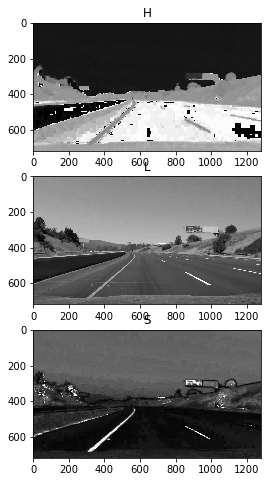

In [13]:
img = mpimg.imread('frames/1.1.jpg')
imgHLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
plt.title('H')
fig =plt.imshow(imgHLS[:,:,0],cmap='gray')
plt.subplot(3,1,2)
plt.title('L')
fig =plt.imshow(imgHLS[:,:,1],cmap='gray')
plt.subplot(3,1,3)
plt.title('S')
fig =plt.imshow(imgHLS[:,:,2],cmap='gray')

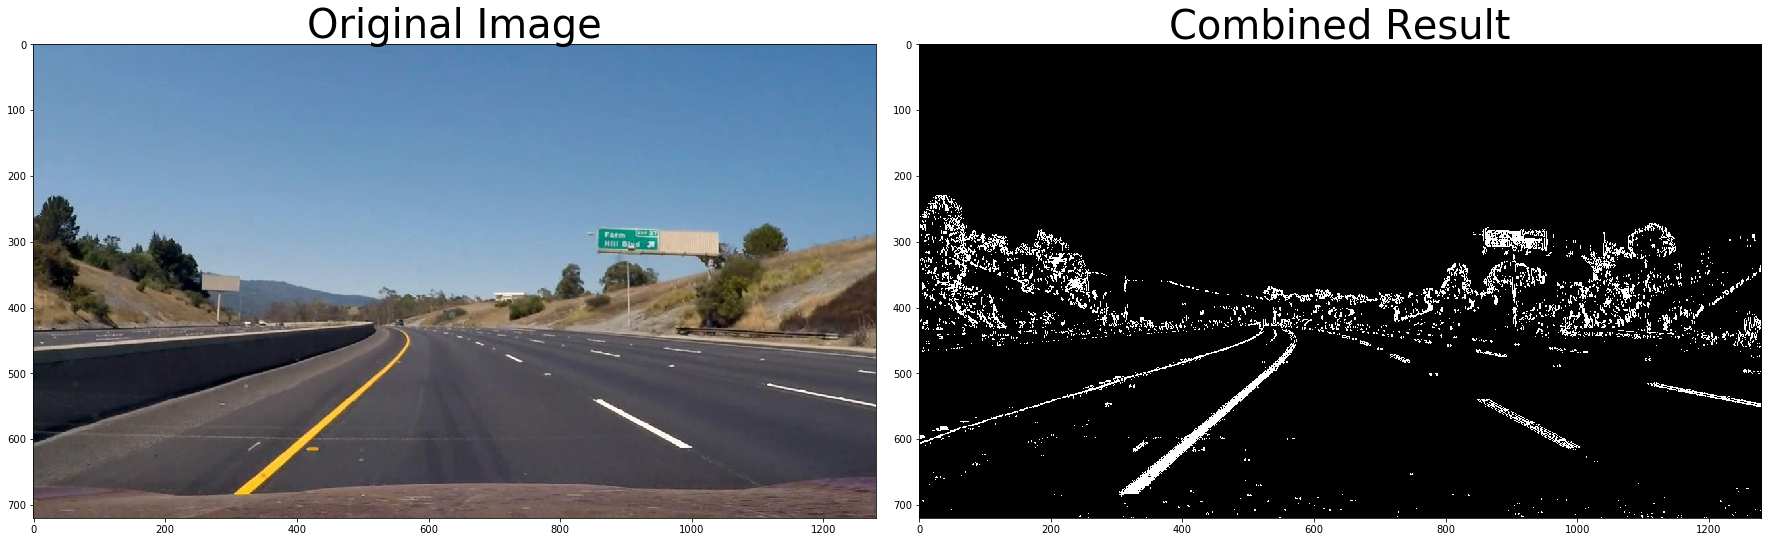

In [14]:
image = mpimg.imread('frames/1.1.jpg')

# Edit this function to create your own pipeline.
def combine_threshold(img, s_thresh=(210, 255), sx_thresh=(20, 100), r_thresh=(10,100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # RGB colour
    r_channel = img[:,:,2]
    
    # Threshold on r
    rbinary = np.zeros_like(r_channel)
    rbinary[(r_channel > r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Convert to HSV
    imgHLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
  
    combined = np.zeros_like(sxbinary)
    combined[(sxbinary == 1)  | (s_binary == 1) | (((rbinary == 1)) & (s_binary == 1)) ] = 1
    return combined
    
result = combine_threshold(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Combined Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform

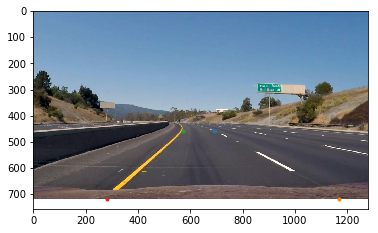

In [15]:
%matplotlib inline

image = mpimg.imread('frames/1.1.jpg')

plt.imshow(img)
plt.plot(690, 460, '.') # top right
plt.plot(1170, 720, '.') # bottom right
plt.plot(570, 460, '.') # top left
plt.plot(280, 720, '.') # bottom left

In [16]:
# function for perspective transform
def warp(img):
    # Define calibration box in source (original) and destination (warped) coordinates
    
    img_size = (img.shape[1], img.shape[0])
    
    # Four source coordinates
    src = np.float32(
        [[690, 460],
         [1180, 720],
         [570, 460],
         [280, 720]])
    
    # Four desired coordinates
    dst = np.float32(
        [[980, 0], 
         [980, 720], 
         [330, 0],
         [330, 720]])
    
    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    
    # create warped image = uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

# function for perspective transform
def unwarp(img):
    # Define calibration box in source (original) and destination (warped) coordinates
    
    img_size = (img.shape[1], img.shape[0])

    # Four source coordinates
    src = np.float32(
        [[690, 460],
         [1180, 720],
         [570, 460],
         [280, 720]])
    
    # Four desired coordinates
    dst = np.float32(
        [[980, 0], 
         [980, 720], 
         [330, 0],
         [330, 720]])

    
    # Compute the inverse perspective transform, M
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # create warped image = uses linear interpolation
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    return Minv

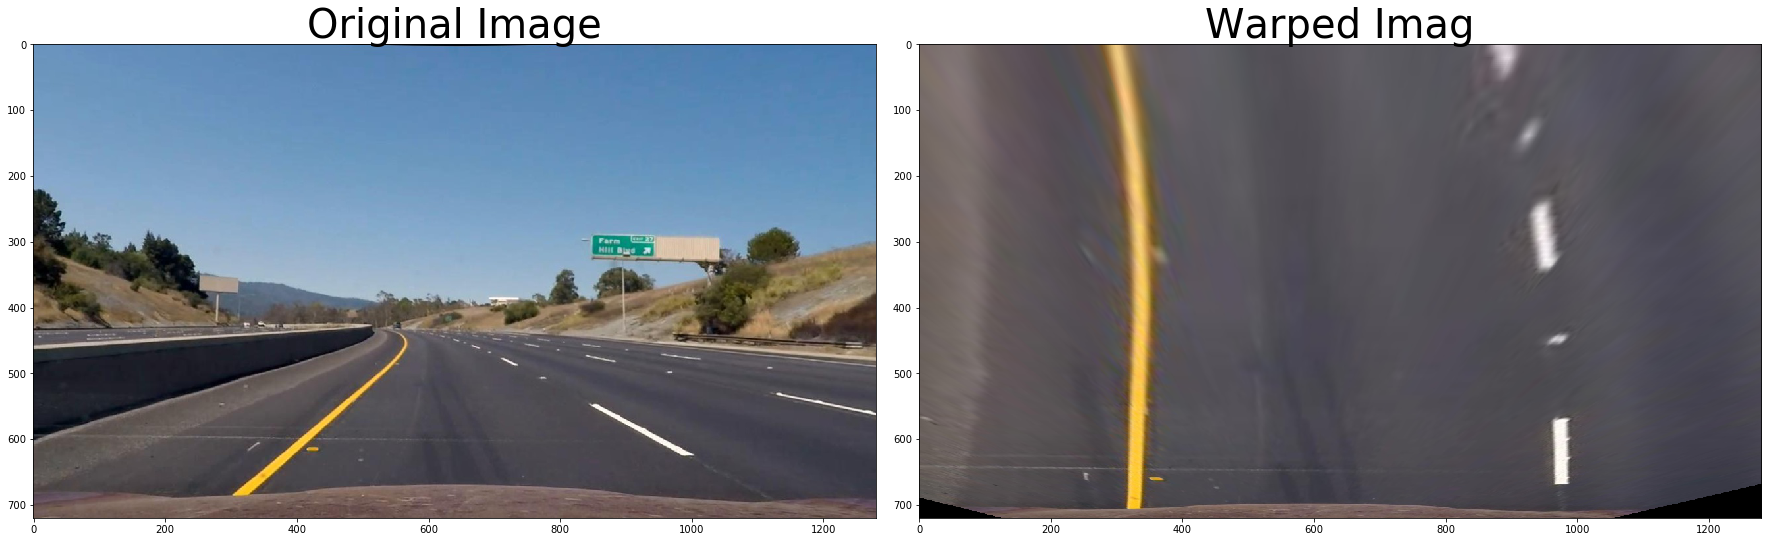

In [17]:
%matplotlib inline

img = mpimg.imread('output_images/car_camera_undistort.jpg')

warpimg = warp(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warpimg)
ax2.set_title('Warped Imag', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



In [18]:
# read in and make a list of calibration images
images = glob.glob('output_images/*_undistort.jpg')

for fname in images:
    # Read each image
    img = mpimg.imread(fname)
    filename = fname.split(os.sep)[-1]
    filename = filename.split('.')[0]
    # Undistort image
    warpimg = warp(img)
    # Save images
    imgdir = 'output_images/'
    img_dis = os.path.join(imgdir, '{}_Bird_eye.jpg'.format(filename))

    cv2.imwrite(img_dis, warpimg[:,:,::-1])
    print (img_dis)


output_images/cal_camera_undistort_Bird_eye.jpg
output_images/car_camera_undistort_Bird_eye.jpg
output_images/straight_lines1_undistort_Bird_eye.jpg
output_images/straight_lines2_undistort_Bird_eye.jpg
output_images/test1_undistort_Bird_eye.jpg
output_images/test2_undistort_Bird_eye.jpg
output_images/test3_undistort_Bird_eye.jpg
output_images/test4_undistort_Bird_eye.jpg
output_images/test5_undistort_Bird_eye.jpg
output_images/test6_undistort_Bird_eye.jpg


## Measure Curvature

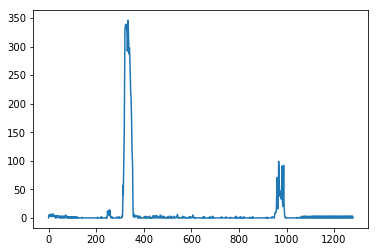

In [19]:
# img = mpimg.imread('output_images/car_camera_undistort.jpg')
img = mpimg.imread('frames/1.1.jpg')

undistorted = undist_vid(img)
warpimg = warp(undistorted)
binary_warped = combine_threshold(warpimg)


histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)


In [123]:
# @run_once
def sliding_window(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, nonzerox, nonzeroy, margin, left_lane_inds, right_lane_inds

(720, 0)

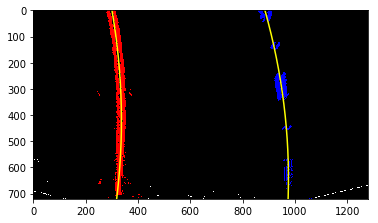

In [73]:
fits = sliding_window(binary_warped)
left_fit = fits[0]
right_fit = fits[1]
nonzerox = fits[2]
nonzeroy = fits[3]
margin = fits[4]
left_lane_inds = fits[5]
right_lane_inds = fits[6]

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Visualization
# At this point, you're done! But here is how you can visualize the result as well:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [67]:
def continuous_fit(left_fit, right_fit, binary_warped):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    return left_fitx, right_fitx, ploty, margin, left_line_pts, right_line_pts

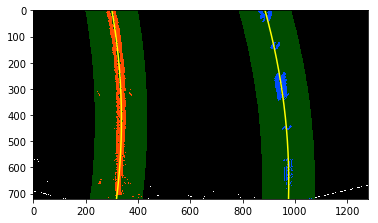

In [23]:
left_fitx, right_fitx, ploty, margin, left_line_pts, right_line_pts = continuous_fit(left_fit, right_fit, binary_warped)

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
pylab.savefig('output_images/car_camera_fitted_lines.png')

In [24]:
def cal_curve(leftx, rightx, binary_warped):
    
    height = binary_warped.shape[0]
    ploty = np.linspace(0, height-1, height)
    y_eval = np.max(ploty)
                    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + \
                           left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + \
                            right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    center_off = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) + \
               (right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix*1000
    return left_curverad, right_curverad, center_off


In [25]:
left_curverad, right_curverad, center_off = cal_curve(left_fitx, right_fitx, binary_warped)

print (left_curverad, 'm', right_curverad, 'm', center_off, 'cm')


791.701609812 m 781.716183155 m 33.66682137 cm


## Drawing Lines

In [26]:
def drawing(warped, undist, left_fit, right_fit, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )

    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

def add_text(left_curverad, right_curverad, center, image):
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    
    #Write curvature and center in image
    lefttxt = "Left curv: " + str(int(left_curverad)) + " m"
    righttxt = "Right curv: " + str(int(right_curverad))+ " m"
    centertx = "Center offset: " + str(round( center,2)) + "cm"

    fontScale=1
    thickness=2

    cv2.putText(image, lefttxt, (130,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(image, righttxt, (130,70), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(image, centertx, (130,100), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    
    return image

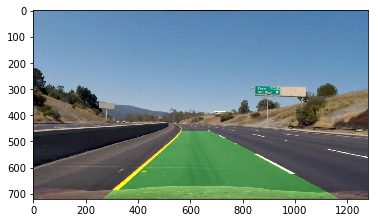

In [27]:
warped = binary_warped
Minv = unwarp(binary_warped)
undist = undistorted

left_fitx, right_fitx, ploty, margin, left_line_pts, right_line_pts = continuous_fit(left_fit, right_fit, binary_warped)
result = drawing(warped, undist, left_fit, right_fit, Minv)

plt.imshow(result)
pylab.savefig('output_images/car_camera_overlay.png')

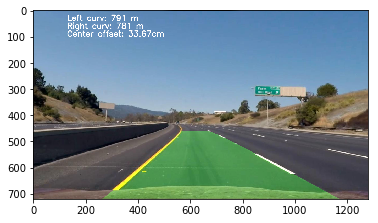

In [28]:
result_text = add_text(left_curverad, right_curverad, center_off, result)
plt.imshow(result_text)
pylab.savefig('output_images/car_camera_overlay_text.png')

## Pipeline

In [100]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, recent_xfitted = [], current_fit = []):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
    def recentx(self, x):
        self.recent_xfitted = []
        return self.recent_xfitted.append(x)
    
    def diffx(self, x):
        return np.subtract(self.recent_xfitted, x)
    
    def setCurrentFit(self, x):
        self.current_fit = []
        return self.current_fit.append(x)

In [130]:
c_left= Line()
c_right = Line()


def process_image(image):
    
    # First undistort image
    undist = undist_vid(image)
    
    # Apply a perspective transform and compute unwarp
    warpimg = warp(undist)
    
    
    # Then treshold warped image
    binary_warped = combine_threshold(warpimg)
    Minv = unwarp(binary_warped)
    
    # Apply Continous window mask to binary_warped
    xleft = np.array(c_left.current_fit).tolist()
    xright = np.array(c_right.current_fit).tolist()
    
    if len(xright) > 0:
        binary_warped = region_of_interest(binary_warped, xleft[0], xright[0])
    
    # Setup run once function for sliding window
    fits = sliding_window(binary_warped)
    left_fit = fits[0]
    right_fit = fits[1]
    nonzerox = fits[2]
    nonzeroy = fits[3]
    margin = fits[4]
    left_lane_inds = fits[5]
    right_lane_inds = fits[6]    

    # Save the fits to Class line
    # c_left.recentx(left_fit)
    # c_right.recentx(right_fit)

    # Do line fitting with continuous detection
    # This will output the line and window to be applied to the next image
    left_fitx, right_fitx, ploty, margin, left_line_pts, right_line_pts = continuous_fit(left_fit, right_fit, binary_warped)
    
    # Save the line points and apply to binary
    c_left.setCurrentFit(left_line_pts)
    c_right.setCurrentFit(right_line_pts)
    
    # get curvature of the lines
    left_curverad, right_curverad, center_off = cal_curve(left_fitx, right_fitx, binary_warped)
    
    # Add drawings and Unwarp
    result = drawing(binary_warped, undist, left_fit, right_fit, Minv)
    
    # Add text
    result_output = add_text(left_curverad, right_curverad, center_off, result)

    return result_output

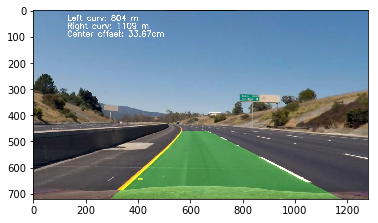

In [131]:
img = mpimg.imread('frames/0.6.jpg')
result = process_image(img)

plt.imshow(result)

## Processing

In [132]:
white_output = 'white.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:36<00:00,  2.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 8min 41s
